In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Introduction

В данном проекте я хочу реализовать весь путь, который проходит проект, начиная со сбора данных и их предобработки, заканчивая подбором гиперпараметров для модели в той или иной задачи.

Обычно такой процесс именуют - пайплайном, где каждой частью рабочего пути занимается отдельная команда людей. В свою же очередь я хочу пробовать раскрыть тонкости той или иной проблемы, отметить, какие навыки присущи специалисту в этой подобласти, посмотреть на различные вариации задач и их решения.

Проект будет составлять из следующих частей:  
**`Парсинг данных`** -> **`Предобработка данных`** -> **`Разведочный анализ данных`** -> **`Разработка моделей машинного обучения`**

Сбор информации или иначе говоря парсинг будет осуществляться с помощью **YouTube Data API v3**.     
Остальные же пункты будут реализованы станадратными для анализа данных фреймворками.

# Modules import

In [2]:
# для предупреждений
import warnings
warnings.filterwarnings('ignore')

# для загрузки обученной модели
import joblib

# для обработки и анализа структурированных данных
from dateutil import parser
import datetime  # для определения дня недели в колонке с датой публикации ролика
import isodate  # перевод длины ролика из формата заданного YouTube -> в секунды
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score


# для визуализации
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import tree
from tqdm import tqdm

# для обучения
RANDOM_STATE = 11
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import torch
import torch.nn as nn
import torch.nn.functional as F

# One YouTube Channel

## Data Collection

Рассмотрим процесс сбора данных для одного канала.

В связи с новой политикой работы Youtube, на данный момент, нельзя получить _**`'истинный'`**_ адрес, нужный для последующей работы. Для примера в таблице ниже показано, как выглядела адресная строка раньше и сейчас:

| Положение                     | Адрес                             |
|------------------------------|----------------------------------|
|**<span style="color:red">Актуально, но неверно</span>**|**~~https://www.youtube.com/@BicepsUaYoutube~~**|
|**<span style="color:green">Неактуально, но верно</span>**|**https://www.youtube.com/UC31A1zxzxVkNJKAzgZH4RYA**|

Следовательно реализуем метод **`get_url()`**, чья суть будет состоять в следующем:
* Получить **_`нерабочий`_** адрес канала от пользователя;
* Открыть код страницы;
* Вернуть **_`рабочий`_** адрес канала, найденный в коде страницы.

In [3]:
from one_channel_class import VideoDataOne, API_KEY, DUMMY_URL_ONE

video_data_one = VideoDataOne(API_KEY, DUMMY_URL_ONE)
channel_id = video_data_one.get_url()
channel_id

'UCBNlINWfd08qgDkUTaUY4_w'

Далее воспользуемся документацией _**`YouTube Data API`**_ и ранее полученным идентификатором, чтобы реализовать функцию **`get_statistics()`**, что будет возвращать **`словарь`** cо значениями основной статистики канала.

Для того, чтобы обратиться к API, используем метод _**`build`**_ из класса _**`googleapiclient`**_.

In [4]:
ch_stat = video_data_one.get_statistics()
print(json.dumps(ch_stat, indent=1, ensure_ascii=False))

{
 "kind": "youtube#channelListResponse",
 "etag": "EdifW9TozTUj8BNsW0CQpek5K7E",
 "pageInfo": {
  "totalResults": 1,
  "resultsPerPage": 5
 },
 "items": [
  {
   "kind": "youtube#channel",
   "etag": "EHaEmaRQ0ZHaLMzQpuXq7-VYNYw",
   "id": "UCBNlINWfd08qgDkUTaUY4_w",
   "snippet": {
    "title": "ExtremeCode",
    "description": "Мемы и к̶о̶д айти",
    "customUrl": "@extremecode",
    "publishedAt": "2011-10-16T10:24:20Z",
    "thumbnails": {
     "default": {
      "url": "https://yt3.ggpht.com/ytc/AGIKgqPYyVx8sNO3BaajhtVuoYoUf4O66wJRHpkOmMX5zw=s88-c-k-c0x00ffffff-no-rj",
      "width": 88,
      "height": 88
     },
     "medium": {
      "url": "https://yt3.ggpht.com/ytc/AGIKgqPYyVx8sNO3BaajhtVuoYoUf4O66wJRHpkOmMX5zw=s240-c-k-c0x00ffffff-no-rj",
      "width": 240,
      "height": 240
     },
     "high": {
      "url": "https://yt3.ggpht.com/ytc/AGIKgqPYyVx8sNO3BaajhtVuoYoUf4O66wJRHpkOmMX5zw=s800-c-k-c0x00ffffff-no-rj",
      "width": 800,
      "height": 800
     }
    },
    "l

Для примера выведем пару статистических значений.

In [5]:
data = {'Никнейм канала': [ch_stat['items'][0]['snippet']['title']],
        'Описание канала': [ch_stat['items'][0]['snippet']['description']],
        'Дата регистрации': ['.'.join(ch_stat['items'][0]['snippet']['publishedAt'][0:10].split('-')[::-1])],
        'Кол-во подписчиков': [int(ch_stat['items'][0]['statistics']['subscriberCount'])],
        'Кол-во просмоторов': [int(ch_stat['items'][0]['statistics']['viewCount'])],
        'Кол-во публикаций': [int(ch_stat['items'][0]['statistics']['videoCount'])]}

df_ch = pd.DataFrame(data=data)
df_ch

,Никнейм канала,Описание канала,Дата регистрации,Кол-во подписчиков,Кол-во просмоторов,Кол-во публикаций
0,ExtremeCode,Мемы и к̶о̶д айти,16.10.2011,265000,28029104,125


Из предыдущего словаря мы также можем найти значение идентификатора загрузочного плейлиста, что в последующем поможет нам получить идентификаторы всех видео на канале. Собственно для этого реализуем метод, что будет возвращать такой **`словарь`**.

Конечно, все это можно написать прям в **`jupyter notebook'e`**, тем не менее для удобства при работе с отладчиком или возможном развитии проекта в будущем: я решил реализовать все это дело через класс в отдельным **`.py`** файле.

In [6]:
ids = video_data_one.get_ids()

assert len(ids) == int(ch_stat['items'][0]['statistics']['videoCount']), 'Кол-во идентификаторов видео ≠ кол-во видео'

Теперь, когда у нас есть идентикфикатор каждого видео на канале, создадим новый __**`DataFrame`**__ со следующими статистическими значениями:

* Идентификатор видео;
* Название канала (в будующем потребуется для таблиц с несколькими пользователями);
* Название ролика;
* Описание ролика;
* Дата публикации;
* Теги;
* Кол - во просмотров;
* Кол - во лайков;
* Кол - во комментариев;
* Длина видео;
* Есть ли субтитры;
* Качество видео (HD или стандартное).

In [7]:
video_df_one = video_data_one.get_data()
video_df_one.head()

,video_id,channelTitle,title,description,publishedAt,tags,viewCount,likeCount,commentCount,duration,caption,definition
0,KpohpURAKUQ,ExtremeCode,ТЕОРИЯ ВСЕГО В ПРОГРАММИРОВАНИИ,🔥 Подавайте заявку в онлайн-магистратуру Инфор...,2023-05-25T06:00:16Z,None,107302,14824,996,PT8M2S,true,hd
1,MBGEj5GKoC8,ExtremeCode,Переигрываем наглых АйТишных менеджеров,Курс «Frontend разработчик» от Kata Academy с ...,2023-05-12T05:58:23Z,None,78216,7707,539,PT8M1S,true,hd
2,OheLxFPZ9DE,ExtremeCode,Как появились АйТи пузыри,Освойте IT-профессию с нуля на курсах от Яндек...,2023-04-24T06:09:16Z,None,100594,8827,439,PT7M13S,true,hd
3,CT5ub18UkrE,ExtremeCode,АйТи ВСЁ. Поехали на завод.,🤖 https://go.productstar.ru/extremecode - Стан...,2023-04-14T05:59:58Z,"[карьера, айти, кризис, финансы, работа, прогр...",168144,13366,834,PT8M11S,true,hd
4,-2QVx-jwJAQ,ExtremeCode,Секреты тестировщиков в АйТи,Курс QA-инженер от Kata Аcademy с оплатой посл...,2023-03-23T05:59:18Z,"[qa, тестирование, работа, профессия, ручное, ...",95757,9227,623,PT7M46S,true,hd


## Data Preprocessing

Рассмотрим наши, пока что еще сырые, данные.

In [8]:
video_df_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      125 non-null    object
 1   channelTitle  125 non-null    object
 2   title         125 non-null    object
 3   description   125 non-null    object
 4   publishedAt   125 non-null    object
 5   tags          111 non-null    object
 6   viewCount     125 non-null    object
 7   likeCount     125 non-null    object
 8   commentCount  125 non-null    object
 9   duration      125 non-null    object
 10  caption       125 non-null    object
 11  definition    125 non-null    object
dtypes: object(12)
memory usage: 11.8+ KB


In [9]:
video_df_one.isnull().mean()

video_id        0.000
channelTitle    0.000
title           0.000
description     0.000
publishedAt     0.000
tags            0.112
viewCount       0.000
likeCount       0.000
commentCount    0.000
duration        0.000
caption         0.000
definition      0.000
dtype: float64

Как мы видим подготовка данных не займет много времени. Какие идеи сразу бросаются в глаза:

* Приведение типов данных к соответствующим
* Замена пропусков в признаке **`tags`** на нули, что логично по смыслу
* Вывод конкретных признаков из общего признака **`publishedAt`**

In [10]:
int_cols = ['viewCount', 'likeCount', 'commentCount']
video_df_one[int_cols] = video_df_one[int_cols].astype('int')

In [11]:
video_df_one['duration'] = video_df_one['duration'].apply(
    lambda x: isodate.parse_duration(x)).astype('timedelta64[m]')

video_df_one['publishedAt_date'] = video_df_one['publishedAt'].apply(
    lambda x: parser.parse(x)).apply(pd.to_datetime)

video_df_one['publishedAt_time'] = video_df_one['publishedAt'].apply(
    lambda x: parser.parse(x)).astype('str').apply(lambda x: x[11:19])

video_df_one['publishedAt_day'] = video_df_one['publishedAt'].apply(
    lambda x: parser.parse(x).strftime('%A'))

In [12]:
video_df_one['caption'] = video_df_one['caption'].astype('bool')
video_df_one['title_length'] = video_df_one['title'].apply(lambda x: len(x))

In [13]:
video_df_one['tags_count'] = video_df_one['tags'].apply(
    lambda x: len(x) if x != None else 0)

video_df_one.drop(columns=['publishedAt', 'tags'], inplace=True)

In [14]:
video_df_one.isnull().mean() == 0

video_id            True
channelTitle        True
title               True
description         True
viewCount           True
likeCount           True
commentCount        True
duration            True
caption             True
definition          True
publishedAt_date    True
publishedAt_time    True
publishedAt_day     True
title_length        True
tags_count          True
dtype: bool

In [15]:
video_df_one.head()

,video_id,channelTitle,title,description,viewCount,likeCount,commentCount,duration,caption,definition,publishedAt_date,publishedAt_time,publishedAt_day,title_length,tags_count
0,KpohpURAKUQ,ExtremeCode,ТЕОРИЯ ВСЕГО В ПРОГРАММИРОВАНИИ,🔥 Подавайте заявку в онлайн-магистратуру Инфор...,107302,14824,996,8.0,True,hd,2023-05-25 06:00:16+00:00,06:00:16,Thursday,31,0
1,MBGEj5GKoC8,ExtremeCode,Переигрываем наглых АйТишных менеджеров,Курс «Frontend разработчик» от Kata Academy с ...,78216,7707,539,8.0,True,hd,2023-05-12 05:58:23+00:00,05:58:23,Friday,39,0
2,OheLxFPZ9DE,ExtremeCode,Как появились АйТи пузыри,Освойте IT-профессию с нуля на курсах от Яндек...,100594,8827,439,7.0,True,hd,2023-04-24 06:09:16+00:00,06:09:16,Monday,25,0
3,CT5ub18UkrE,ExtremeCode,АйТи ВСЁ. Поехали на завод.,🤖 https://go.productstar.ru/extremecode - Стан...,168144,13366,834,8.0,True,hd,2023-04-14 05:59:58+00:00,05:59:58,Friday,27,6
4,-2QVx-jwJAQ,ExtremeCode,Секреты тестировщиков в АйТи,Курс QA-инженер от Kata Аcademy с оплатой посл...,95757,9227,623,7.0,True,hd,2023-03-23 05:59:18+00:00,05:59:18,Thursday,28,7


## Exploratory Data Analysis

Как итог мы получаем следующий датасет:  

|Название признака|Тип данных|Описание признака|
|----------|----------|----------|
|**`video_id`**|**`str`**|**`Id видео`**|
|**`channelTitle`**|**`str`**|**`Название канала`**|
|**`title`**|**`str`**|**`Название ролика`**|
|**`description`**|**`str`**|**`Описание ролика`**|
|**`viewCount`**|**`int`**|**`Кол-во просмотров`**|
|**`likeCount`**|**`int`**|**`Кол-во лайков`**|
|**`commentCount`**|**`int`**|**`Кол-во комментариев`**|
|**`duration`**|**`float`**|**`Длительность видео в минутах`**|
|**`caption`**|**`bool`**|**`Наличие субтитров`**|
|**`definition`**|**`str`**|**`HD или стандартное разрешение(SD)`**|
|**`publishedAt_date`**|**`datetime`**|**`Дата публикации`**|
|**`publishedAt_time`**|**`str`**|**`Время публикации`**|
|**`publishedAt_day`**|**`str`**|**`День публикации`**|
|**`tags_count`**|**`int`**|**`Кол-во тегов`**|
|**`title_length`**|**`int`**|**`Длина названия ролика`**|

In [16]:
video_df_one.describe().T

,count,mean,std,min,25%,50%,75%,max
viewCount,125.0,224358.040,239447.378250,33463.0,124285.0,168144.0,236366.0,2351283.0
likeCount,125.0,12675.752,10849.037578,1216.0,6707.0,10007.0,16058.0,98247.0
commentCount,125.0,662.256,692.787391,29.0,220.0,457.0,974.0,6155.0
duration,125.0,7.384,4.009634,0.0,6.0,8.0,9.0,23.0
title_length,125.0,35.200,13.646458,13.0,25.0,32.0,42.0,69.0
tags_count,125.0,8.456,5.071273,0.0,5.0,9.0,12.0,23.0


In [17]:
video_df_one.describe(include=object).T

,count,unique,top,freq
video_id,125,125,KpohpURAKUQ,1
channelTitle,125,1,ExtremeCode,125
title,125,125,ТЕОРИЯ ВСЕГО В ПРОГРАММИРОВАНИИ,1
description,125,120,💰 Бонусы за спонсорство\nhttps://www.youtube.c...,4
definition,125,1,hd,125
publishedAt_time,125,124,05:59:58,2
publishedAt_day,125,7,Friday,28


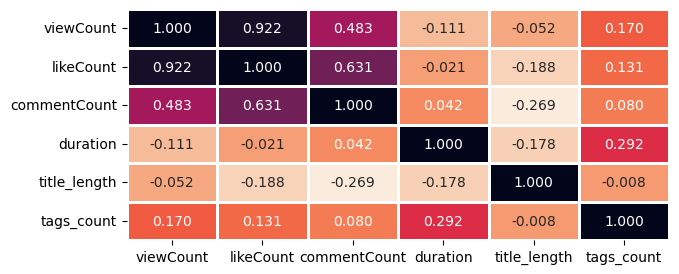

In [18]:
plt.figure(figsize=[7, 3])
sns.heatmap(data=video_df_one.drop(columns='caption').corr(),
            linewidths=0.8,
            annot=True,
            fmt='.3f',
            cbar=False,
            cmap='rocket_r');

Как мы видим, есть высокая положительная корреляция между **`количеством лайков и количеством просмотров`**.

Средняя положительная корреляция между **`количеством комменатриев и количеством просмотров`** и **`количеством комменатриев и количеством лайков`**.

Слабая положительаня корреляция между **`количеством тэгов и длительностью видео`**.

А также слабая отрицательная корреляция между **`количеством комменатриев и длинной заголовка видео`**.

Для примера визуализируем следующие аналитические идеи:

- Распределение длительности видео, длины описаний, количества лайков, комментариев, просмотров и тэгов;
- В какие дни и в какое время в среднем выходят видео;
- Сравним, как просмоторы зависят от комменатриев и количества лайков;
- Зависимость длины ролика от количества тэгов.

### Numerical histograms

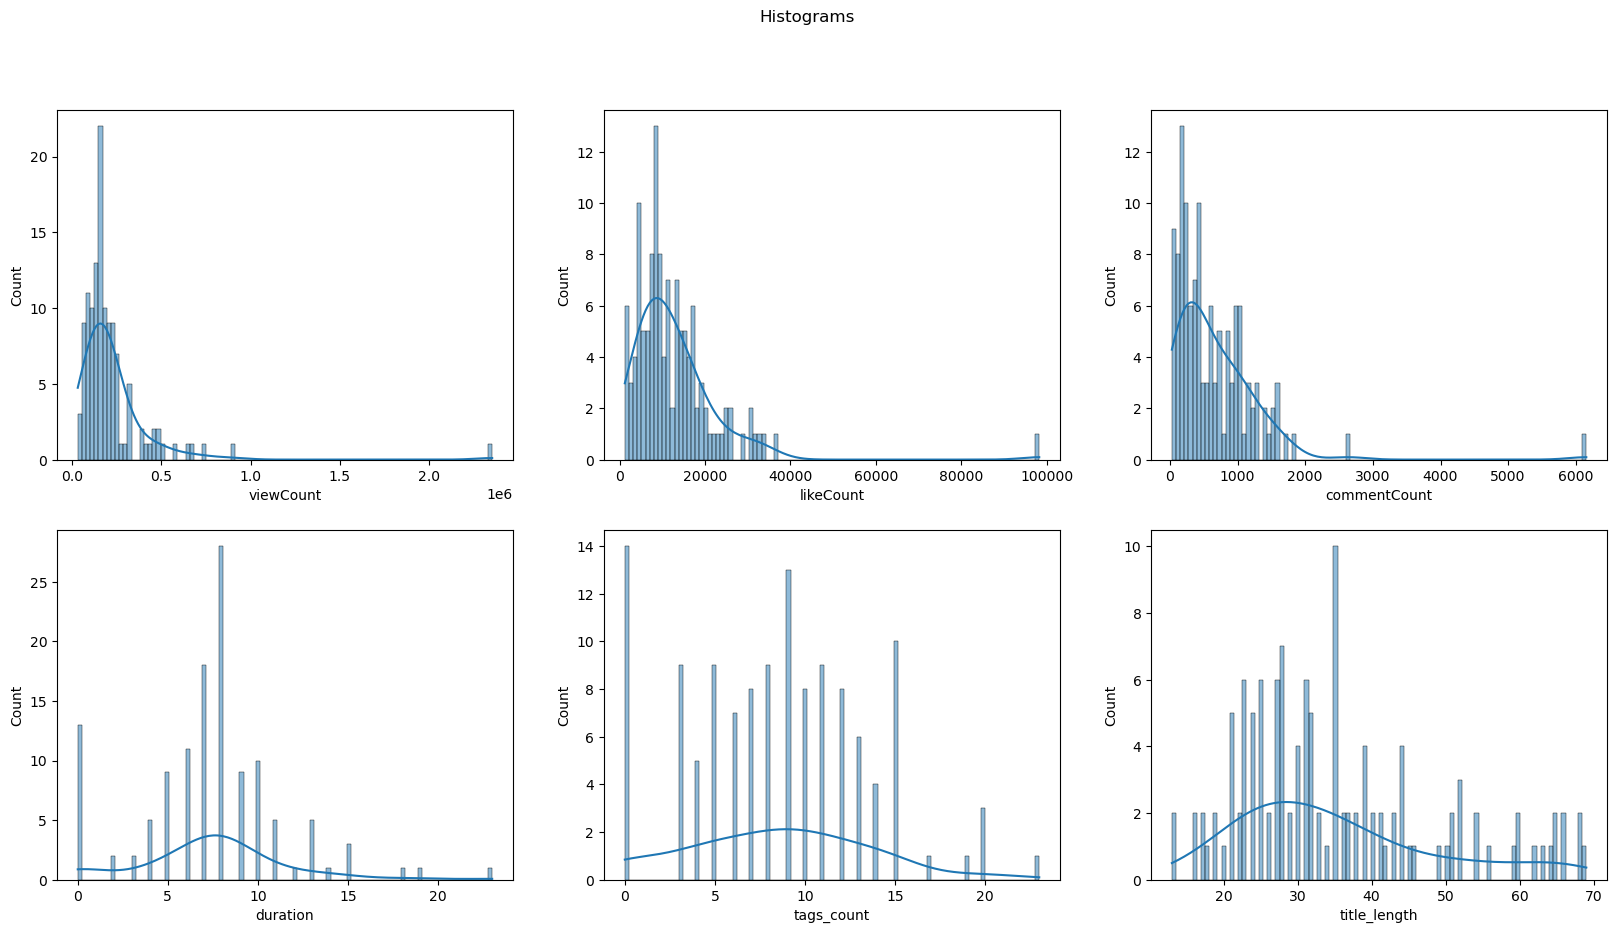

In [19]:
numerical_cols = ['viewCount', 'likeCount', 'commentCount',
                  'duration', 'tags_count', 'title_length']
plt.figure(figsize=(20, 10))
row = 2
col = 3
plt.suptitle('Histograms')


for i in range(6):
    plt.subplot(row, col, i + 1)
    sns.histplot(data=video_df_one[numerical_cols[i]], bins=100, kde=True)

Как мы видим в некоторых случаях распределение стремится к нормальному.

### Video schedule

In [20]:
days_cols = ['Monday', 'Tuesday', 'Wednesday',
             'Thursday', 'Friday', 'Saturday', 'Sunday']
days_df_one = pd.DataFrame(video_df_one['publishedAt_day'].value_counts()).reindex(days_cols)
days_df_one

,publishedAt_day
Monday,17
Tuesday,25
Wednesday,15
Thursday,19
Friday,28
Saturday,12
Sunday,9


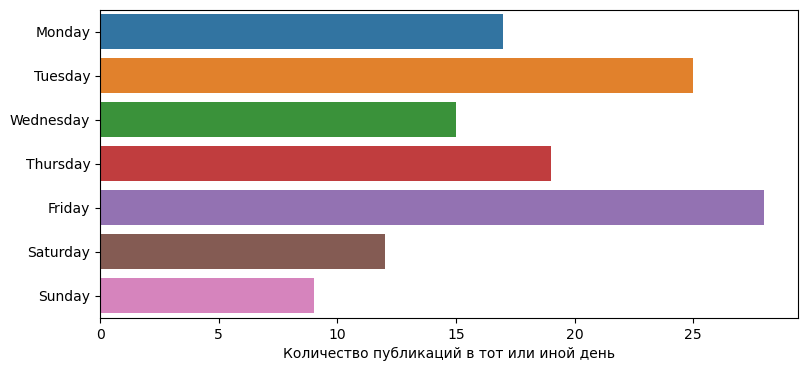

In [21]:
plt.figure(figsize=[9, 4])
sns.barplot(x=days_df_one['publishedAt_day'],
            y=days_df_one.index)
plt.xlabel('Количество публикаций в тот или иной день');

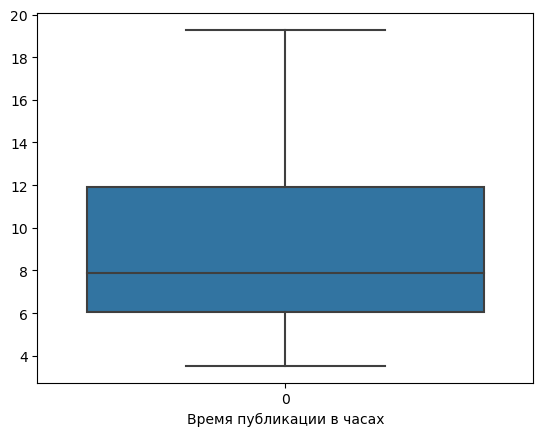

In [22]:
video_df_one['publishedAt_time_hour'] = video_df_one['publishedAt_time'].apply(lambda x: (int(x[0:2]) * 3600 + int(x[3:5]) * 60 + int(x[6:])) / 3600)
sns.boxplot(data=video_df_one['publishedAt_time_hour'])
plt.xlabel('Время публикации в часах');

Медиана по времени публикации роликов примерно равна 8 часам. Опять же, вспоминая какой канал мы анализируем, подобные результаты вполне оправданы.

### Relation between count views, comments and count likes

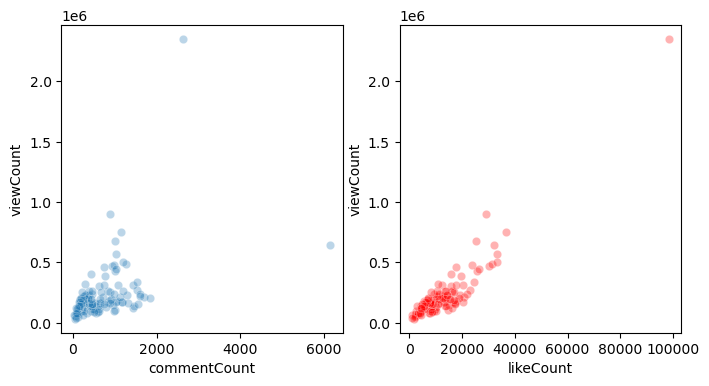

In [23]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
sns.scatterplot(data=video_df_one, x='commentCount', y='viewCount', alpha=0.3)
plt.subplot(1, 2, 2)
sns.scatterplot(data=video_df_one, x='likeCount', y='viewCount', alpha=0.3, color='red');

Благодаря параметру **`alpha`**, что отвечает за прозрачность точек, мы можем видеть интенсивность сэмплов. Таким образом на втором графике заметна динамика, некая вытянутость рассматриваемых объектов.

### Length of videos from tags

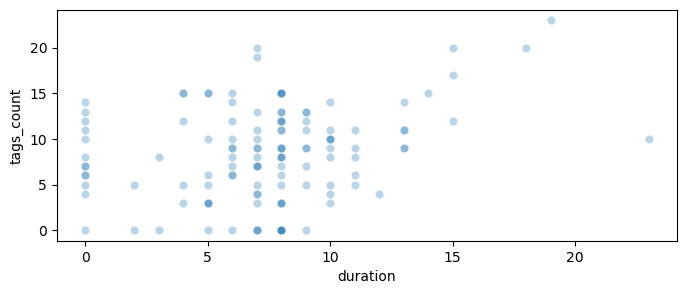

In [24]:
plt.figure(figsize=[8, 3])
sns.scatterplot(data=video_df_one, x='duration', y='tags_count', alpha=0.3);

Какой же микровывод мы можем сделать, глядя на этот график?! Как по мне, нету особой тенденции наподобии **`чем длинеее ролик, тем больше кол-во тегов у этого ролика, ну и соответственно наоборот`**. Задатки на такое есть, правда если смотреть только на правую часть графика. Все же интереснее рассмотреть этот тезис в случае с несколькими каналами.

## Training ML Models

In [25]:
video_df_one.shape

(125, 16)

В связи с тем, что у нас довольно маленькая выборка, то для случая, где мы анализруем лишь **`один YouTube канал`**, решим задачу бинариной классификации: **`классификация положительных и негативных комментариев`**. 

Поэтому для начала спарсим комментарии под всеми роликами. Для экономии ресурсов, что выдаются пользователю, будем сохранять комментарии без учета последующих ответов на них: 

In [26]:
'''
class CommentsData:
    def __init__(self, api_key: str, video_ids: list) -> None:
        self.api_key = api_key
        self.video_ids = video_ids

    def get_comments(self) -> pd.DataFrame:
        data = []

        youtube = build('youtube', 
                        'v3', 
                        developerKey=self.api_key)

        for id_index in self.video_ids:
            next_page_token = ''
            while next_page_token != None:
                request = youtube.commentThreads().list(part="snippet,replies",
                                                        videoId=id_index,
                                                        maxResults=10,
                                                        pageToken=next_page_token)
                response = request.execute()

                for comment in response['items']:
                    all_comments = comment['snippet']['topLevelComment']['snippet']['textOriginal']
                    comments_with_id = {
                        'video_id': id_index, 'comments': all_comments}
                    data += [comments_with_id]
                    next_page_token = response.get('nextPageToken')

        return pd.DataFrame(data)
'''
print()

Запрос для получения одного комменатрия стоит **`1 условную единицу`** из 10 000 возможных, что даются пользователю с самого старта и обновляющиеся каждые сутки. Конечно можно потратить все условные единицы и в конце концов получать по 10 000 комментариев в сутки, однако в связи с тем, что данные единицы требуются и для других запросов, то для своего проекта я ограничусь **`всеми комментариями за последние 5 видео`** для тестовой выборки.

In [27]:
'''
%%time
from googleapiclient.discovery import build
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv())
API_KEY = os.getenv('API_KEY')

if len(ids) < 5:
    comments_data = CommentsData(API_KEY, ids[0:len(ids)])
else:
    comments_data = CommentsData(API_KEY, ids[0:5])

comments_df = comments_data.get_comments()
comments_df.shape
'''
print()

В связи с тем, что парсинг комментариев, даже под 5 крайними видео, занимает десяток минут, то сделаем конвертирование **`DataFrame -> .xlsx`**, а также закомментируем ячейки кода, отвечающие за сбор комментарием под роликами, так как я использую однокнопочный запуск всех ячеек благодаря функциям _jupyter notebook_.

In [28]:
# comments_df.to_excel(path, index_label=True)

In [29]:
path = './data/comments.xlsx'
comments_df = pd.read_excel(path)
comments_df.head()

,Unnamed: 0,video_id,comments
0,0,KpohpURAKUQ,❤Подпишись на Telegram: https://t.me/extremeco...
1,1,KpohpURAKUQ,"Ебейший контент 10/10, вот бы взять не просто ..."
2,2,KpohpURAKUQ,хотелось бы ссылочку на литературу
3,3,KpohpURAKUQ,"Нихуя не понял, давай ещё, ты красавчик!"
4,4,KpohpURAKUQ,Супер 🎉❤


Далее у нас есть два выбора пути развития:  
1) Спарсить большое кол-во комментариев, вручную разметить датасет и именно на нем проводить, как тренировку, так и валидацию с тестированием. Плюсом такого подхода является следующий момент: так как канал один, то и субкультура комментариев под этими роликами примерна не отличается друг от друга. Поэтому при обучении модели на этом датасете, модель получается более **`чувственной`** к тонкостям этого канала.

2) Найти уже готовый размеченный датасет, на котором мы обучим модель. И далее на размеченных комментариях будет рассматривать показания метрик для задачи классификации.

**`Я выбрал второй подход.`**

# Several YouTube Channels

## Data Collection

Теперь же рассмотрим процесс сбора данных для нескольких каналов. Так как данная операция незначительно отличается от операции сбора данных с одного канала, то реализуем эти действия **`через другой .py файл`**.

In [30]:
from many_channels_class import VideoDataSeveral, API_KEY, DUMMY_URL

video_data_several = VideoDataSeveral(API_KEY, DUMMY_URL)
video_data_several.get_url()
video_data_several.get_statistics()
video_data_several.get_playlists_id()
video_data_several.get_ids()
video_df_several = video_data_several.get_data()
video_df_several.head()

,video_id,channelTitle,title,description,publishedAt,tags,viewCount,likeCount,commentCount,duration,caption,definition
0,KpohpURAKUQ,ExtremeCode,ТЕОРИЯ ВСЕГО В ПРОГРАММИРОВАНИИ,🔥 Подавайте заявку в онлайн-магистратуру Инфор...,2023-05-25T06:00:16Z,None,107302,14824,996,PT8M2S,true,hd
1,MBGEj5GKoC8,ExtremeCode,Переигрываем наглых АйТишных менеджеров,Курс «Frontend разработчик» от Kata Academy с ...,2023-05-12T05:58:23Z,None,78216,7707,539,PT8M1S,true,hd
2,OheLxFPZ9DE,ExtremeCode,Как появились АйТи пузыри,Освойте IT-профессию с нуля на курсах от Яндек...,2023-04-24T06:09:16Z,None,100594,8827,439,PT7M13S,true,hd
3,CT5ub18UkrE,ExtremeCode,АйТи ВСЁ. Поехали на завод.,🤖 https://go.productstar.ru/extremecode - Стан...,2023-04-14T05:59:58Z,"[карьера, айти, кризис, финансы, работа, прогр...",168144,13366,834,PT8M11S,true,hd
4,-2QVx-jwJAQ,ExtremeCode,Секреты тестировщиков в АйТи,Курс QA-инженер от Kata Аcademy с оплатой посл...,2023-03-23T05:59:18Z,"[qa, тестирование, работа, профессия, ручное, ...",95757,9227,623,PT7M46S,true,hd


In [31]:
video_df_several.shape

(5819, 12)

## Data Preprocessing

In [32]:
video_df_several.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819 entries, 0 to 5818
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   video_id      5819 non-null   object
 1   channelTitle  5819 non-null   object
 2   title         5819 non-null   object
 3   description   5819 non-null   object
 4   publishedAt   5819 non-null   object
 5   tags          5510 non-null   object
 6   viewCount     5819 non-null   object
 7   likeCount     5810 non-null   object
 8   commentCount  5815 non-null   object
 9   duration      5819 non-null   object
 10  caption       5819 non-null   object
 11  definition    5819 non-null   object
dtypes: object(12)
memory usage: 545.7+ KB


In [33]:
video_df_several.isnull().mean()

video_id        0.000000
channelTitle    0.000000
title           0.000000
description     0.000000
publishedAt     0.000000
tags            0.053102
viewCount       0.000000
likeCount       0.001547
commentCount    0.000687
duration        0.000000
caption         0.000000
definition      0.000000
dtype: float64

Как мы видим, в отличии от случая с одним каналом, в случае с несколькими можно заметить, что под некоторыми роликами отключены комменатарии и скрыты лайки. В связи с этим от нас потребуется произвести дополнительные действия в предварительной обработке. Тем не менее так как подобных экземпляров у нас мало, то можно попросту заменить их на нули.

Остальные же моменты аналогичны случаю предварительной обработке данных одного канала.

In [34]:
int_cols = ['viewCount', 'likeCount', 'commentCount']
video_df_several['likeCount'] = video_df_several['likeCount'].fillna(0)
video_df_several['commentCount'] = video_df_several['commentCount'].fillna(0)
video_df_several[int_cols] = video_df_several[int_cols].astype('int')

In [35]:
video_df_several['duration'] = video_df_several['duration'].apply(
    lambda x: isodate.parse_duration(x)).astype('timedelta64[m]')

video_df_several['publishedAt_date'] = video_df_several['publishedAt'].apply(
    lambda x: parser.parse(x)).apply(pd.to_datetime)

video_df_several['publishedAt_time'] = video_df_several['publishedAt'].apply(
    lambda x: parser.parse(x)).astype('str').apply(lambda x: x[11:19])

video_df_several['publishedAt_day'] = video_df_several['publishedAt'].apply(
    lambda x: parser.parse(x).strftime('%A'))

In [36]:
video_df_several['tags_count'] = video_df_several['tags'].apply(
    lambda x: len(x) if x != None else 0)

video_df_several['title_length'] = video_df_several['title'].apply(lambda x: len(x))

In [37]:
video_df_several.drop(columns=['publishedAt', 'tags'], inplace=True)
video_df_one['caption'] = video_df_one['caption'].astype('bool')

In [38]:
video_df_several.isnull().mean() == 0

video_id            True
channelTitle        True
title               True
description         True
viewCount           True
likeCount           True
commentCount        True
duration            True
caption             True
definition          True
publishedAt_date    True
publishedAt_time    True
publishedAt_day     True
tags_count          True
title_length        True
dtype: bool

## Exploratory Data Analysis

Вспомним еще раз какой датасет мы получаем в итоге:   

|Название признака|Тип данных|Описание признака|
|----------|----------|----------|
|**`video_id`**|**`str`**|**`Id видео`**|
|**`channelTitle`**|**`str`**|**`Название канала`**|
|**`title`**|**`str`**|**`Название ролика`**|
|**`description`**|**`str`**|**`Описание ролика`**|
|**`viewCount`**|**`int`**|**`Кол-во просмотров`**|
|**`likeCount`**|**`int`**|**`Кол-во лайков`**|
|**`commentCount`**|**`int`**|**`Кол-во комментариев`**|
|**`duration`**|**`float`**|**`Длительность видео в минутах`**|
|**`caption`**|**`bool`**|**`Наличие субтитров`**|
|**`definition`**|**`str`**|**`HD или стандартное разрешение(SD)`**|
|**`publishedAt_date`**|**`datetime`**|**`Дата публикации`**|
|**`publishedAt_time`**|**`str`**|**`Время публикации`**|
|**`publishedAt_day`**|**`str`**|**`День публикации`**|
|**`tags_count`**|**`int`**|**`Кол-во тегов`**|
|**`title_length`**|**`int`**|**`Длина названия ролика`**|

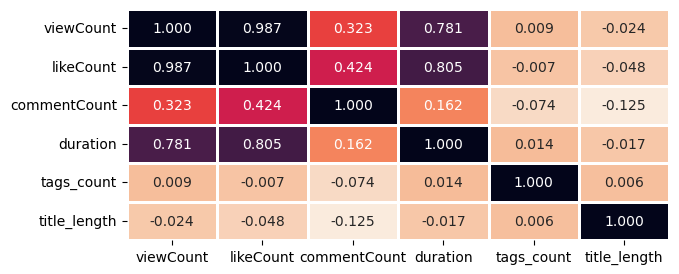

In [39]:
plt.figure(figsize=[7, 3])
sns.heatmap(data=video_df_several.corr(),
            linewidths=0.8,
            annot=True,
            fmt='.3f',
            cbar=False,
            cmap='rocket_r');

Из корреляционной матрицы видно, что прошлые положительные зависимости стали более явными и заметными, а прошлые старые отрициательные зависимости - почти обнулились, также можно отметить появление новых положительных взаимосвязей.

В случае с несколькими каналами **`рассмотрим, а также визуально сравним те же гипотезы`**, что и для случая с исследованием лишь одного канала. А именно:
- Гистограмма длительности видео, длины описаний, количества лайков, комментариев, просмотров и тэгов;
- В какие дни и в какое время в среднем выходят видео;
- Сравним, как просмоторы зависят от комменатриев и количества лайков;
- Зависимость длины ролика от количества тэгов.

### Numerical histograms

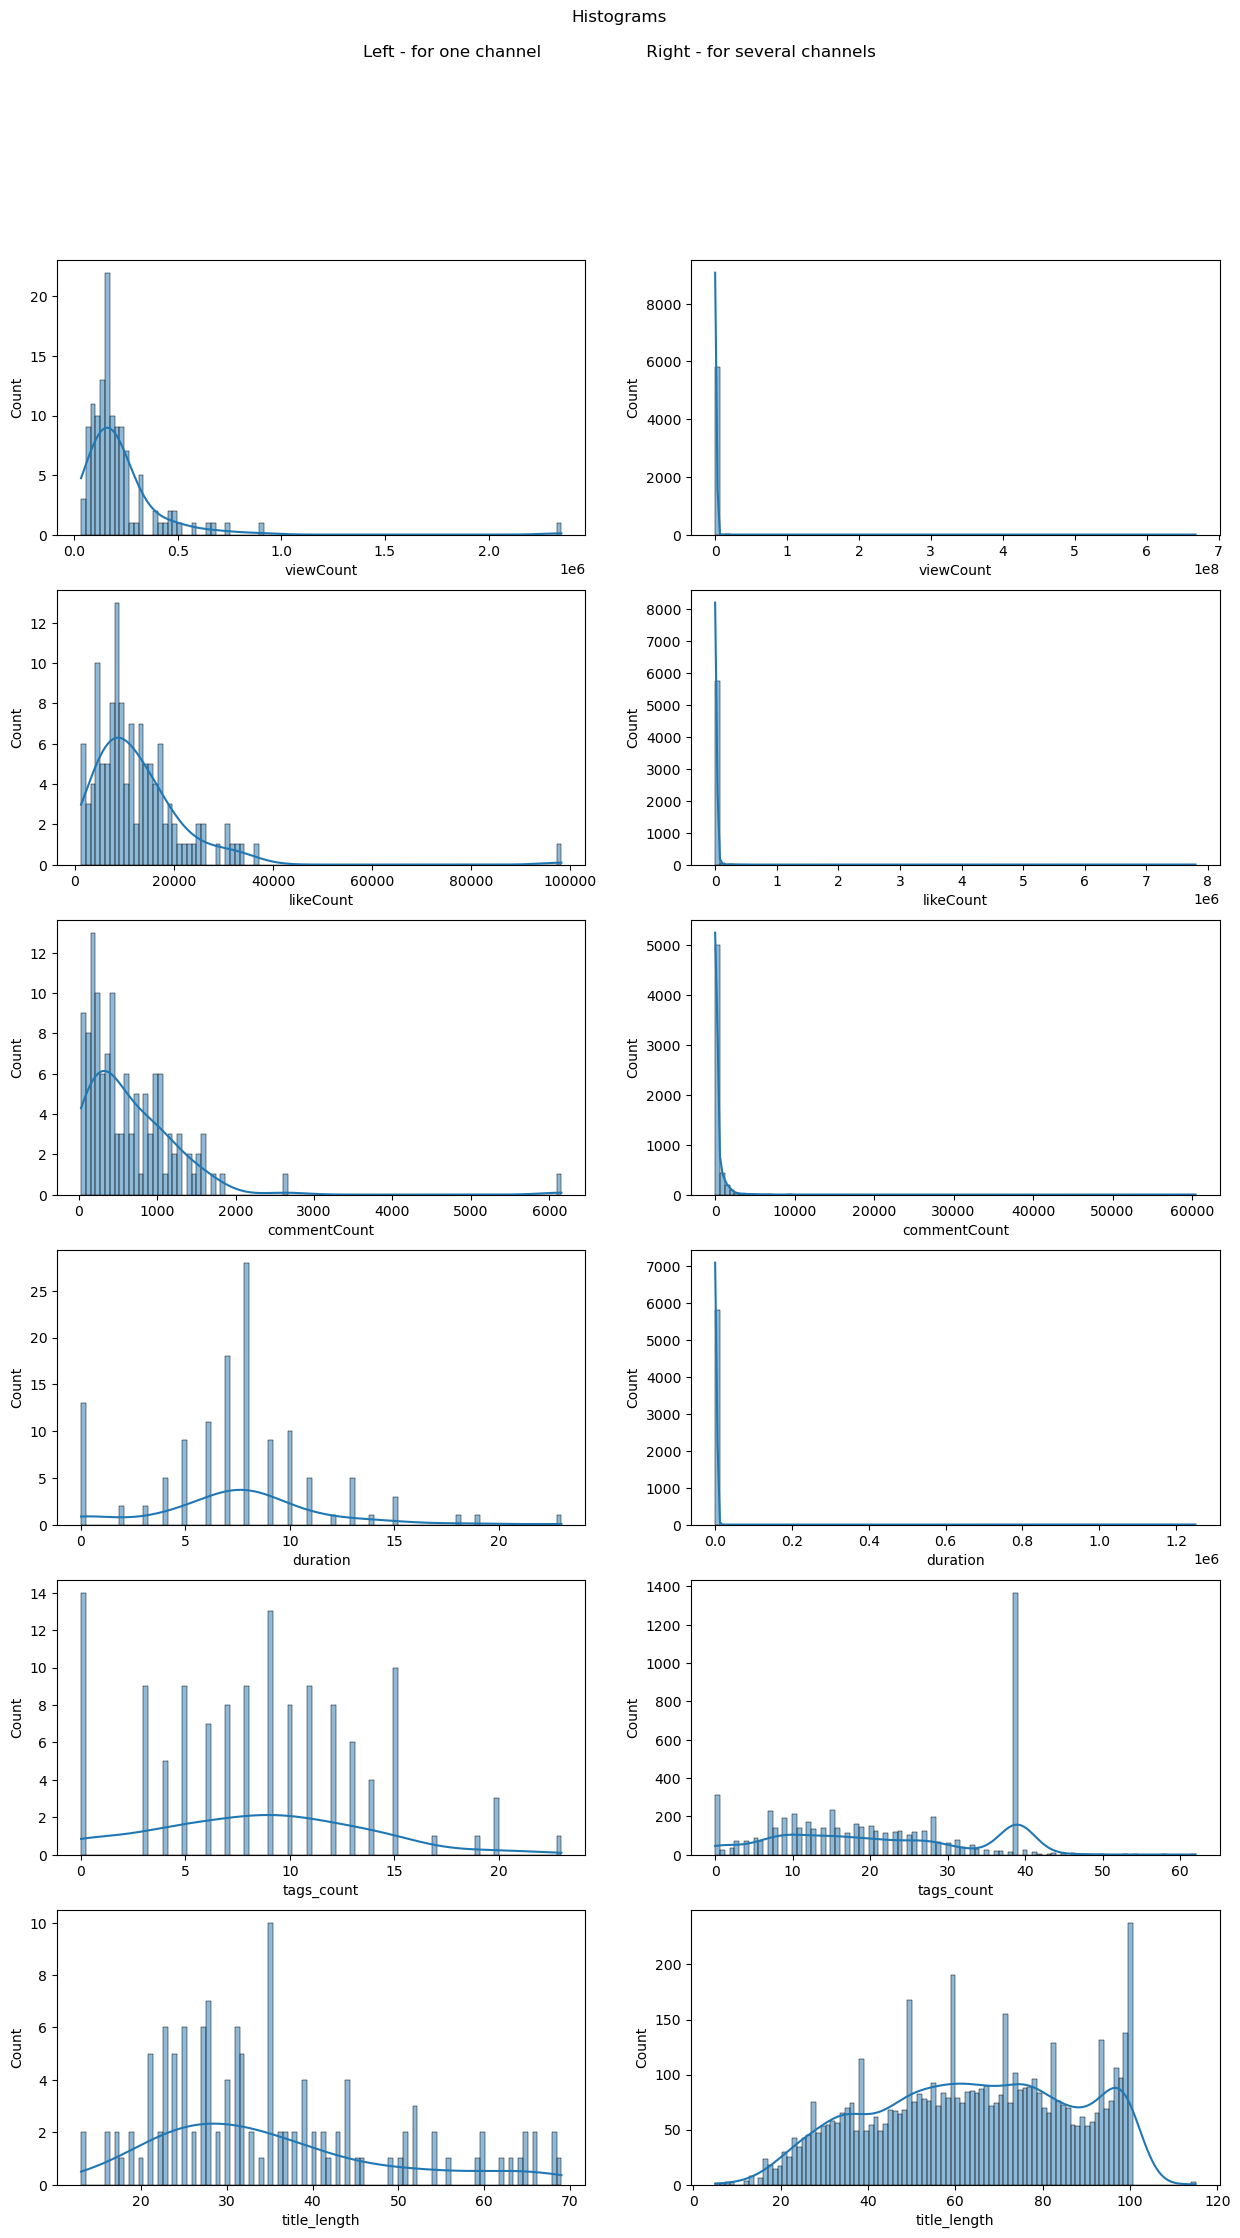

In [40]:
numerical_cols = ['viewCount', 'likeCount', 'commentCount',
                  'duration', 'tags_count', 'title_length']
plt.figure(figsize=(15, 25))
row = 6
col = 2
plt.suptitle('Histograms\n\nLeft - for one channel' + ' ' * 20 + 'Right - for several channels')

for i in range(12):
    plt.subplot(row, col, i + 1)
    if i % 2 == 0:
        sns.histplot(data=video_df_one[numerical_cols[i // 2]], bins=100, kde=True);
    else:
        sns.histplot(data=video_df_several[numerical_cols[i // 2]], bins=100, kde=True);

Какие выводы можно сделать:

* Функции плотности на первых трех графиках - схожи. Опять же данный факт вытекает из простых рассуждений. 
* Функции плотности же последних трех графиков разнятся в зависимости от увеличения кол-ва каналов. Это обоснованы ведь **`один автор предпочитает длинные заголовки, другой - короткие`**; **`один большое кол-во тегов, другой - малое кол-во тегов`**; **`один базируется на длинных роликах, другой - нет`**. 

### Video schedule

In [41]:
days_cols = ['Monday', 'Tuesday', 'Wednesday',
             'Thursday', 'Friday', 'Saturday', 'Sunday']
days_df_several = pd.DataFrame(video_df_several['publishedAt_day'].value_counts()).reindex(days_cols)
days_df_several

,publishedAt_day
Monday,956
Tuesday,769
Wednesday,793
Thursday,874
Friday,860
Saturday,717
Sunday,850


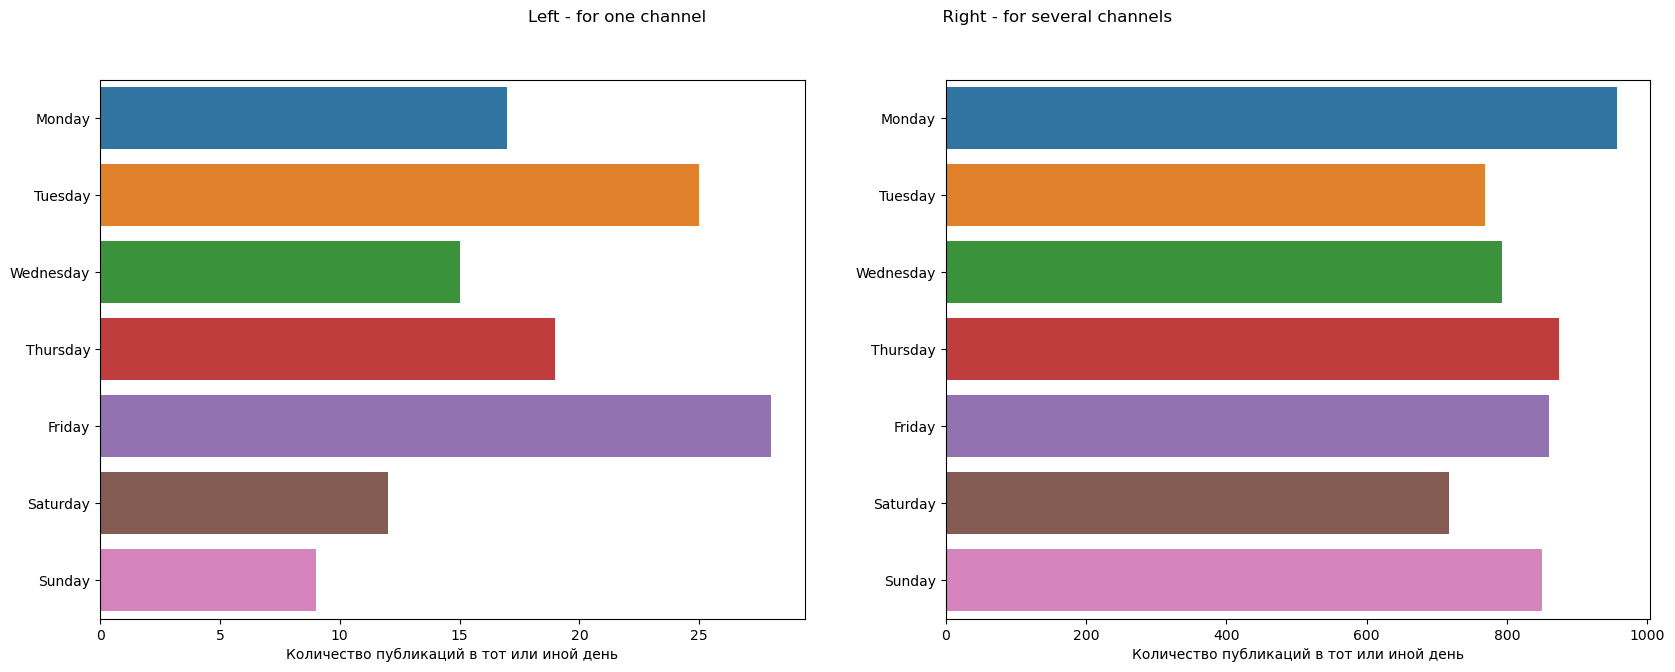

In [42]:
plt.figure(figsize=[20, 7])

plt.subplot(1, 2, 1)
sns.barplot(x=days_df_one['publishedAt_day'],
            y=days_df_one.index)
plt.xlabel('Количество публикаций в тот или иной день');

plt.subplot(1, 2, 2)
sns.barplot(x=days_df_several['publishedAt_day'],
            y=days_df_several.index)
plt.xlabel('Количество публикаций в тот или иной день');

plt.suptitle('Left - for one channel' + ' ' * 45 + 'Right - for several channels');

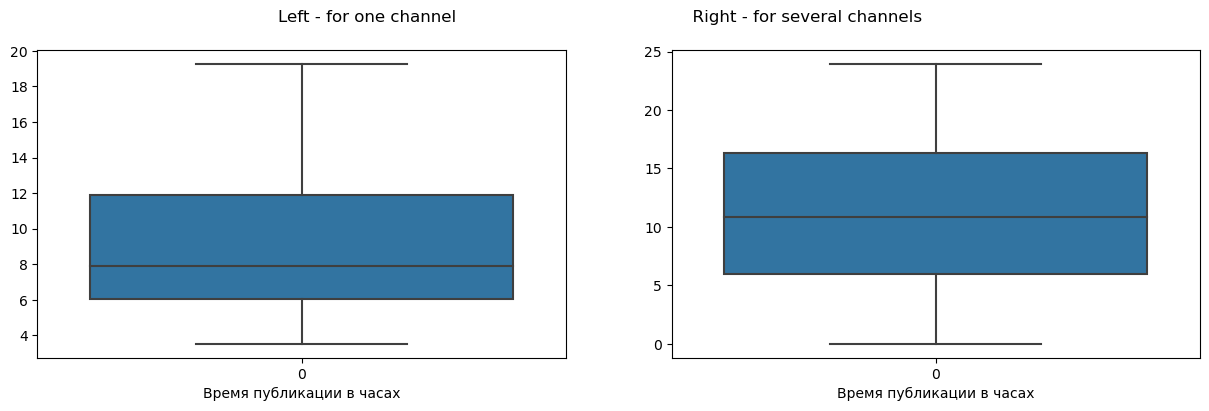

In [43]:
plt.figure(figsize=[15, 4])
video_df_several['publishedAt_time_hour'] = video_df_several['publishedAt_time'].apply(lambda x: (int(x[0:2]) * 3600 + int(x[3:5]) * 60 + int(x[6:])) / 3600)

plt.subplot(1, 2, 1)
sns.boxplot(data=video_df_one['publishedAt_time_hour'])
plt.xlabel('Время публикации в часах');

plt.subplot(1, 2, 2)
sns.boxplot(data=video_df_several['publishedAt_time_hour'])
plt.xlabel('Время публикации в часах');

plt.suptitle('Left - for one channel' + ' ' * 45 + 'Right - for several channels');

Здесь мы можем дать лишь среднюю оценку времени публикации роликов.

### Relation between count views, comments and count likes

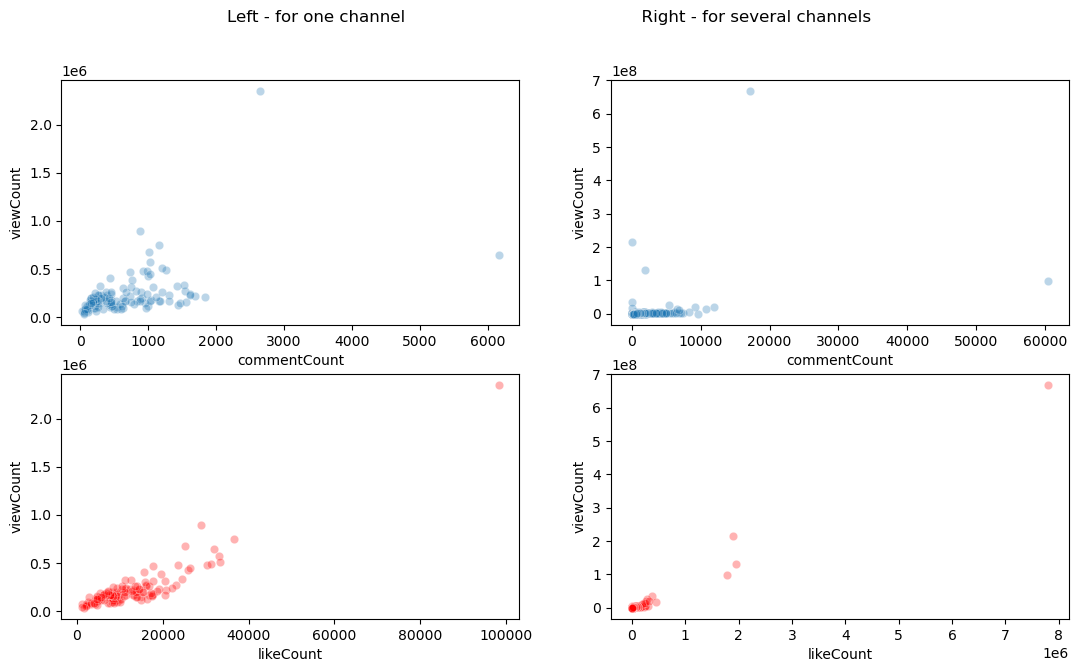

In [44]:
plt.figure(figsize=[13,7])

plt.subplot(2, 2, 1)
sns.scatterplot(data=video_df_one, x='commentCount', y='viewCount', alpha=0.3)

plt.subplot(2, 2, 2)
sns.scatterplot(data=video_df_several, x='commentCount', y='viewCount', alpha=0.3)

plt.subplot(2, 2, 3)
sns.scatterplot(data=video_df_one, x='likeCount', y='viewCount', alpha=0.3, color='red');

plt.subplot(2, 2, 4)
sns.scatterplot(data=video_df_several, x='likeCount', y='viewCount', alpha=0.3, color='red');

plt.suptitle('Left - for one channel' + ' ' * 45 + 'Right - for several channels');

При увеличении кол-ва рассматриваемых каналов, очертания случая для одного канала - сохраняются.

### Length of videos from tags

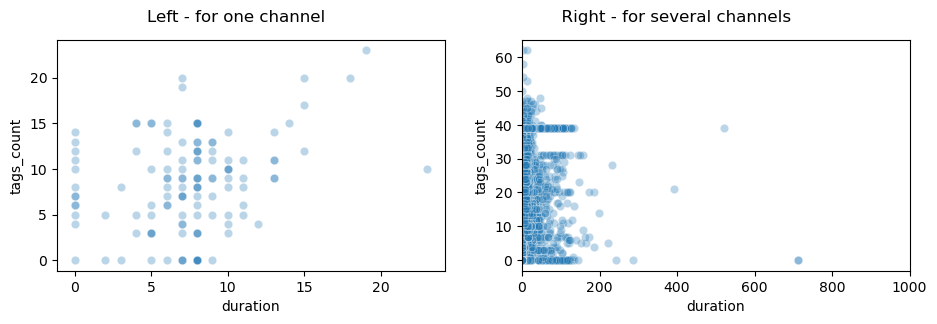

In [45]:
plt.figure(figsize=[11, 3])

plt.subplot(1, 2, 1)
sns.scatterplot(data=video_df_one, x='duration', y='tags_count', alpha=0.3);

plt.subplot(1, 2, 2)
sns.scatterplot(data=video_df_several, x='duration', y='tags_count', alpha=0.3);
plt.xlim(0, 1000)

plt.suptitle('Left - for one channel' + ' ' * 45 + 'Right - for several channels');

Опять же видно, что какие-то каналы предпочитают большое кол-во тегов, а какие-то нет.

## Training ML Models

Рассмотрим задачу регрессии:

**`Предсказывание кол-во лайков по другим признакам с помощью классического машинного обучения, а также при помощи фрейморвка для глубоких нейронных сетей PyTorch.`**


**`В ходе проекта было замечено, что с добавлением авторами новых видео - меняется подбор гиперпарметров для той или иной модели. В связи с этим мои комментарии через какое-то время могут стать ложными, либо немного отойти от истины.`**

In [46]:
df = video_df_several.copy()
df.head()

,video_id,channelTitle,title,description,viewCount,likeCount,commentCount,duration,caption,definition,publishedAt_date,publishedAt_time,publishedAt_day,tags_count,title_length,publishedAt_time_hour
0,KpohpURAKUQ,ExtremeCode,ТЕОРИЯ ВСЕГО В ПРОГРАММИРОВАНИИ,🔥 Подавайте заявку в онлайн-магистратуру Инфор...,107302,14824,996,8.0,true,hd,2023-05-25 06:00:16+00:00,06:00:16,Thursday,0,31,6.004444
1,MBGEj5GKoC8,ExtremeCode,Переигрываем наглых АйТишных менеджеров,Курс «Frontend разработчик» от Kata Academy с ...,78216,7707,539,8.0,true,hd,2023-05-12 05:58:23+00:00,05:58:23,Friday,0,39,5.973056
2,OheLxFPZ9DE,ExtremeCode,Как появились АйТи пузыри,Освойте IT-профессию с нуля на курсах от Яндек...,100594,8827,439,7.0,true,hd,2023-04-24 06:09:16+00:00,06:09:16,Monday,0,25,6.154444
3,CT5ub18UkrE,ExtremeCode,АйТи ВСЁ. Поехали на завод.,🤖 https://go.productstar.ru/extremecode - Стан...,168144,13366,834,8.0,true,hd,2023-04-14 05:59:58+00:00,05:59:58,Friday,6,27,5.999444
4,-2QVx-jwJAQ,ExtremeCode,Секреты тестировщиков в АйТи,Курс QA-инженер от Kata Аcademy с оплатой посл...,95757,9227,623,7.0,true,hd,2023-03-23 05:59:18+00:00,05:59:18,Thursday,7,28,5.988333


Применим **`One-Hot Encoding`** для признака **`publishedAt_day`**, а также несколько преобразований бинарных категориальных переменных в численные бинарные.

In [47]:
df['target'] = df['likeCount']
df.drop(columns=['video_id', 'channelTitle', 'title', 'description', 'publishedAt_date', 
                 'publishedAt_time', 'likeCount'], inplace=True)

df['caption'] = df['caption'].apply(lambda x: 1 if x == True else 0)
df['definition'] = df['definition'].apply(lambda x: 1 if x == 'hd' else 0)
df = pd.get_dummies(data=df, columns=['publishedAt_day'], prefix='day', drop_first=True)

In [48]:
df.head()

,viewCount,commentCount,duration,caption,definition,tags_count,title_length,publishedAt_time_hour,target,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,107302,996,8.0,0,1,0,31,6.004444,14824,0,0,0,1,0,0
1,78216,539,8.0,0,1,0,39,5.973056,7707,0,0,0,0,0,0
2,100594,439,7.0,0,1,0,25,6.154444,8827,1,0,0,0,0,0
3,168144,834,8.0,0,1,6,27,5.999444,13366,0,0,0,0,0,0
4,95757,623,7.0,0,1,7,28,5.988333,9227,0,0,0,1,0,0


Разделим данные на тренировочные и тестовые в пропорции 7 / 3, а после применим масштабирование. 

In [49]:
y = df['target']
X = df.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=RANDOM_STATE)

mm = MinMaxScaler()
X_train_sc = mm.fit_transform(X_train)
X_test_sc = mm.transform(X_test)

Проверим три мат модели для задачи регрессии:

1. **`Линейная регрессия`**
2. **`Дерево решений`**
3. **`XGBoost`**

Выберем самый оптимальный вариант, ориентируясь на две метрики:

1. **`MAE -> 0`**
2. **`R2 -> 1`**

Далее напишем простую модель при помощи фреймворка **`PyTorch`** и сравним результаты метрик с предыдущим победителем из семейства классических алгоритмов.

И в конце концов, определившись с наилучшей моделью, спарсим данные с нового канала, чтобы проверить показания метрик на этой модели.

**Линейная регрессия:**

In [50]:
clf_lr = LinearRegression(n_jobs=-1)
clf_lr.fit(X_train_sc, y_train)
y_pred_lr_train = clf_lr.predict(X_train_sc)
y_pred_lr_test = clf_lr.predict(X_test_sc)

print('Метрики на train выборке:')
print(mean_absolute_error(y_train, y_pred_lr_train), r2_score(y_train, y_pred_lr_train))
print('\nМетрики на test выборке:')
print(mean_absolute_error(y_test, y_pred_lr_test), r2_score(y_test, y_pred_lr_test))

Метрики на train выборке:
3212.5121248625383 0.9938163864633092

Метрики на test выборке:
3044.8829824496465 0.7758278797845249


Как мы можем заметить модель вполне нормально обучилась. Попробуем развить идею при помощи применения **`L2`** регуляризации для разных коэффицентов лямбда. В данном случае, назовем модель оптимальной, если её метрики будут оптимальными именно на **`test разбиении`**.

In [51]:
%%time
alphas = list(np.logspace(-100, 100, 10000))
optimal_alpha = 0
min_mae = 1e5
max_r2 = -100
y_pred_ridge_train = 0
y_pred_ridge_test = 0

for alpha in alphas:
    clf_ridge = Ridge(alpha=alpha).fit(X_train_sc, y_train)
    dummy_y_pred_ridge_train = clf_ridge.predict(X_train_sc)
    dummy_y_pred_ridge_test = clf_ridge.predict(X_test_sc)
    
    if (mean_absolute_error(y_train, dummy_y_pred_ridge_train) < min_mae) and (r2_score(y_train, dummy_y_pred_ridge_train) > max_r2):
        optimal_alpha = alpha
        min_mae = mean_absolute_error(y_test, dummy_y_pred_ridge_test)
        max_r2 = r2_score(y_test, dummy_y_pred_ridge_test)
        y_pred_ridge_train = dummy_y_pred_ridge_train
        y_pred_ridge_test = dummy_y_pred_ridge_test

print(f'alpha = {optimal_alpha}\n')
print('Метрики на train выборке:')
print(mean_absolute_error(y_train, y_pred_ridge_train), r2_score(y_train, y_pred_ridge_train))
print('\nМетрики на test выборке:')
print(mean_absolute_error(y_test, y_pred_ridge_test), r2_score(y_test, y_pred_ridge_test))

print()

alpha = 1e-100

Метрики на train выборке:
3212.512124862553 0.9938163864633092

Метрики на test выборке:
3044.882982449667 0.7758278797845246

CPU times: user 46 s, sys: 952 ms, total: 46.9 s
Wall time: 38.5 s


Во - первых результаты идентичны модели обычной линейной регрессии;  
Во - вторых, как мы видим лучший показатели метрик достигаются при минимальном коэффиценте регуляризации, вследствие чего можем сделать вывод, что **`наша линейная модель имеет крайне большие веса`**.  

Проверим это:

In [52]:
clf_lr.coef_

array([ 6.75430786e+06,  8.00492036e+05,  7.15831489e+05, -9.89530236e-10,
        7.49396398e+02, -3.55182527e+03, -4.72376257e+03,  1.01703777e+03,
        6.26955864e+02,  6.06996837e+02,  1.40630659e+03,  1.39464091e+03,
        2.77692079e+02,  7.60439119e+02])

**Дерево решений:**

In [53]:
%%time
tree = DecisionTreeRegressor()
param_tree = {'criterion': ['absolute_error', 'poisson'], 
              'max_depth': [10], 
              'min_samples_split': [2, 4, 6], 
              'min_samples_leaf': [1, 2, 3], 
              'random_state': [RANDOM_STATE]}

clf_tree = GridSearchCV(estimator=tree, 
                        param_grid=param_tree, 
                        cv=3, 
                        verbose=0,
                        n_jobs=-1)
clf_tree.fit(X_train_sc, y_train)

CPU times: user 245 ms, sys: 120 ms, total: 364 ms
Wall time: 12.1 s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['absolute_error', 'poisson'],
                         'max_depth': [10], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6], 'random_state': [11]})

In [54]:
clf_tree.best_estimator_

DecisionTreeRegressor(criterion='poisson', max_depth=10, random_state=11)

In [55]:
'''
from sklearn import tree # почему-то через import вначале проекта - не работает 
tree.plot_tree(clf_tree.best_estimator_);
'''
print()

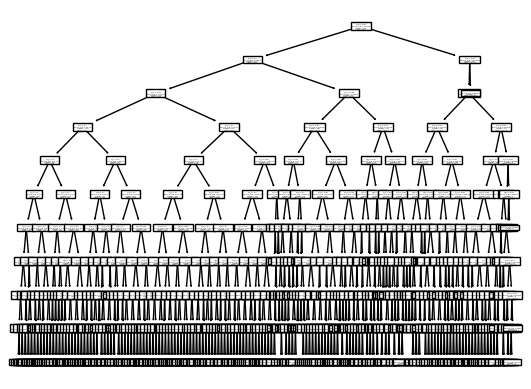

In [56]:
y_pred_tree_train = clf_tree.best_estimator_.predict(X_train_sc)
y_pred_tree_test = clf_tree.best_estimator_.predict(X_test_sc)

print('Метрики на train выборке:')
print(mean_absolute_error(y_train, y_pred_tree_train), r2_score(y_train, y_pred_tree_train))
print('\nМетрики на test выборке:')
print(mean_absolute_error(y_test, y_pred_tree_test), r2_score(y_test, y_pred_tree_test))

Метрики на train выборке:
907.9811784303464 0.9996579777544289

Метрики на test выборке:
1941.326532638467 0.8044479461437226


Даже на такой малой глублине виден факт переобучния. Причиной могут являться неоптимальный выбор таких параметров как:

- Максимальная глубина дерева
- Минимальное кол-во сэмплов в листе
- Минимальное кол-во сэмплов для разделения

Тем не менее чаще всего сама модель дерева решений склонна к переобучению, в отличии от её _развитых версий_.

**XGBoost:**

Опять же, так как я запускаю все ячейки разом, а тренировка **`XGBoost`** занимает много времени, то после успешного обучения я сохраню параметры модели и в последующих запусках буду попросту их импортировать.

In [57]:
'''
%%time
boost = xgb.XGBRegressor()
param_boost = {'learning_rate': [0.5, 0.1, 0.05], 
               'n_estimators': [100, 500, 1000], 
               'n_jobs': [-1], 
               'max_depth': [10, 50, 100],
               'random_state': [RANDOM_STATE]}

clf_boost = GridSearchCV(estimator=boost, 
                        param_grid=param_boost, 
                        cv=3, 
                        verbose=0,
                        n_jobs=-1)

clf_boost_on_save = clf_boost.fit(X_train_sc, y_train)
'''
print()

In [58]:
'''
filename = '/data/xgboost_model.sav
joblib.dump(clf_boost_on_save, filename)
'''
print()

In [59]:
filename = 'data/xgboost_model.sav'
clf_boost_loading = joblib.load(filename)
clf_boost_loading.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=11, ...)

In [60]:
y_pred_boost_train = clf_boost_loading.best_estimator_.predict(X_train_sc)
y_pred_boost_test = clf_boost_loading.best_estimator_.predict(X_test_sc)

print('Метрики на train выборке:')
print(mean_absolute_error(y_train, y_pred_boost_train), r2_score(y_train, y_pred_boost_train))
print('\nМетрики на test выборке:')
print(mean_absolute_error(y_test, y_pred_boost_test), r2_score(y_test, y_pred_boost_test))

Метрики на train выборке:
728.9546423699335 0.998468033262157

Метрики на test выборке:
712.5591556316099 0.9566227549942411


Как итог **`XGBoost`** показывает наилучшие результаты. Именно её мы и будем сравнивать с крайней моделью.

Теперь же реализуем модель для задачи регрессии при помощи фреймворка **`PyTorch`**:

Для начала зафиксируем сиды для генераторов случайных чисел.

In [74]:
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

Теперь переведем наши масштабированные данные тренировочной и тестовой выборки в тензоры.

In [75]:
X_train_tensor = torch.from_numpy(X_train_sc)
y_train_tensor = torch.from_numpy(y_train.values)
X_test_tensor = torch.from_numpy(X_test_sc)
y_test_tensor = torch.from_numpy(y_test.values)

class Neural_

In [ ]:
device = torch.device('cuda:0' 
                      if torch.cuda.is_available() 
                      else 'cpu')
model = model.to(device)

Реализуем, а после вызовем отдельный файл, что спарсит данные и сделает необходимую предобработку.

In [62]:
from one_channel_class import VideoDataOne, API_KEY, DUMMY_URL_TEST

video_data_test = VideoDataOne(API_KEY, DUMMY_URL_TEST)
video_data_test.get_url()
video_data_test.get_statistics()
video_data_test.get_ids()
video_data_test.get_data()
video_df_test = video_data_test.data_preprocessing()
video_df_test.head()

,viewCount,commentCount,duration,caption,definition,title_length,tags_count,publishedAt_time_hour,target,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,107302,996,8.0,1,1,31,0,6.004444,14824,0,0,0,1,0,0
1,78216,539,8.0,1,1,39,0,5.973056,7707,0,0,0,0,0,0
2,100594,439,7.0,1,1,25,0,6.154444,8827,1,0,0,0,0,0
3,168144,834,8.0,1,1,27,6,5.999444,13366,0,0,0,0,0,0
4,95757,623,7.0,1,1,28,7,5.988333,9227,0,0,0,1,0,0


Теперь же применим масштабирование. Стоит отметить, что к данным мы применим метод **`mm.transform`**, а не **`mm.fit_transform`**.